# data

Object detection is a crucial algorithm in the field of computer vision. It serves as the foundation for many applications and is essential in solving certain problems. We will delve into the various components involved in implementing object detection.

The starting point for all of this is data. we will use [Pascal VOC dataset](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/#devkit) as a starting point. we choose this dataset because it is small in size and easy to iterate with. 

We only use `pytorch` to code up most of these things. 

In [ ]:
#| default_exp data

In [ ]:
#| export 
import torch
import PIL 
import numpy as np 
import xml.etree.ElementTree as ET

from PIL import Image

In [ ]:
from pathlib import Path

In [ ]:
root = Path("../data/VOCdevkit/VOC2012/")
list(root.glob("*"))

[PosixPath('../data/VOCdevkit/VOC2012/ImageSets'),
 PosixPath('../data/VOCdevkit/VOC2012/SegmentationClass'),
 PosixPath('../data/VOCdevkit/VOC2012/.DS_Store'),
 PosixPath('../data/VOCdevkit/VOC2012/SegmentationObject'),
 PosixPath('../data/VOCdevkit/VOC2012/Annotations'),
 PosixPath('../data/VOCdevkit/VOC2012/JPEGImages')]

In [ ]:
annots = list((root / "Annotations").glob("*.xml"))
annot = annots[20]

In [ ]:
tree = ET.parse(annot)
xml_root = tree.getroot()
filename = xml_root.find('filename').text
filename

'2011_002421.jpg'

In [ ]:
for boxes in xml_root.iter('object'):
    cat = boxes.find("name").text
    ymin = int(boxes.find("bndbox/ymin").text)
    xmin = int(boxes.find("bndbox/xmin").text)
    ymax = int(boxes.find("bndbox/ymax").text)
    xmax = int(boxes.find("bndbox/xmax").text)
    print([xmin, ymin, xmax, ymax, cat])

[48, 22, 399, 262, 'boat']


In [ ]:
#| export 
VOC_CLASSES = ["person", "bird", "cat", "cow", "dog", "horse", "sheep", \
               "aeroplane", "bicycle", "boat", "bus", "car", "motorbike", "train", \
               "bottle", "chair", "diningtable", "pottedplant", "sofa", "tvmonitor"]

In [ ]:
VOC_CLASSES.index(cat), len(VOC_CLASSES)

(9, 19)

In [ ]:
#| export 
def voc_xml_annot_2_bbox_cat(xml_loc):
    "code copied with slight changes from `https://stackoverflow.com/questions/53317592/reading-pascal-voc-annotations-in-python`"
    xml_root = ET.parse(xml_loc).getroot()
    bboxes, cats = [], []
    for boxes in xml_root.iter('object'):
        cat = boxes.find("name").text
        bbox = [int(boxes.find(f"bndbox/{i}").text) for i in ["xmin", "ymin", "xmax", "ymax"]]
        bboxes.append(bbox)
        cats.append(cat)
    cat_ids = np.asarray([VOC_CLASSES.index(i)+1 for i in cats])
    return np.asarray(bboxes), cat_ids, cats

In [ ]:
bbox, cat_ids, cats = voc_xml_annot_2_bbox_cat(annots[np.random.randint(len(annots))])
bbox, cat_ids, cats

(array([[352, 111, 396, 249],
        [274, 114, 309, 228],
        [178, 109, 211, 197],
        [ 82, 116, 117, 207]]),
 array([1, 1, 1, 1]),
 ['person', 'person', 'person', 'person'])

> Lets visualize a few images 

> write a pytorch dataset 

> visualize the images 

> write a basic dataloader 

## Visualizing images 

In [ ]:
#| export 
def image_grid(imgs, rows, cols):
    #from fastai course2
    if not isinstance(imgs[0], PIL.Image.Image): imgs = [Image.fromarray(img) for img in imgs]
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [ ]:
#| export 
def thumbnail(img, size=128):
    if not isinstance(img, PIL.Image.Image): img = Image.fromarray(img)
    w, h = img.size
    ar = h/w 
    return img.resize((size, int(size*ar)))

In [ ]:
imgs_list = list((root/"JPEGImages").glob("*"))
len(imgs_list), imgs_list[0]

(17125, PosixPath('../data/VOCdevkit/VOC2012/JPEGImages/2008_008336.jpg'))

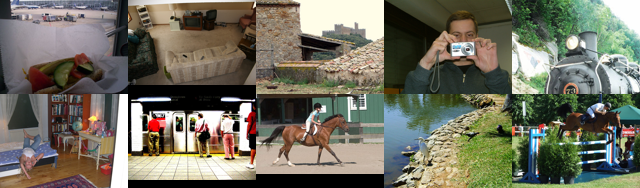

In [ ]:
## Lets visualize a few images
imgs = [Image.open(imgs_list[np.random.randint(len(imgs_list))]) for i in range(10)]
imgs = [thumbnail(img, size=128) for img in imgs]
image_grid(imgs, 2, 5)

In [ ]:
Path("../data/VOCdevkit/VOC2012/ImageSets/Main/train.txt").read_text().rsplit("\n")[:5]

['2008_000008', '2008_000015', '2008_000019', '2008_000023', '2008_000028']

In [ ]:
#| export 
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, root: str, train: bool=True, transforms=None):
        self.root=root
        self.transforms = transforms 
        self.train = train
        self.ids = (root/f"ImageSets/Main/{'train' if train else 'val'}.txt").read_text().rsplit("\n")
    
    def __getitem__(self, idx):
        img_dict = {}
        idx = self.ids[idx] if isinstance(idx, int) else idx 
        img = Image.open(self.root / "JPEGImages" / f"{idx}.jpg")
        img_dict["img"] = np.asarray(img)
        bbox, cat_ids, cats = voc_xml_annot_2_bbox_cat(self.root / "Annotations" / f"{idx}.xml")
        img_dict["bbox"] = bbox 
        img_dict["cat_ids"] = cat_ids
        img_dict["cats"] = cats
        if self.transforms is not None: return self.transforms(img_dict) 
        return img_dict
        
    def __len__(self): return len(self.ids)  

In [ ]:
#| export 
def load_data(name, **kwargs):
    if name=="voc": return VOCDataset(**kwargs)
    else: raise NotImplementedError("only voc is implemented")

In [ ]:
ds = VOCDataset(root, train=True)
ds = load_data("voc", root=root, train=True, transforms=None)
len(ds)

5718

In [ ]:
img = ds[np.random.randint(len(ds))]
img["img"].shape, img["bbox"], img["cat_ids"], img["cats"]

((330, 500, 3), array([[ 99,  63, 481, 330]]), array([2]), ['bird'])

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()